# Language Modelling with LSTM
---
In this module we will be looking at the Language Modelling task. Given vocabulary $V = \{w_i | \forall i \in {0,\ldots, N}\}$ and a sequence of tokens $x_0, x_1, \ldots x_{T-1}$ we want
\begin{align}
  P(x_T | x_{T-1}, x_{T-2}, \ldots x_0) \simeq P(x_T | x_{T-1}, x_{T-2}, \ldots x_{T-k})
\end{align}
Where $x_i \in V \quad \forall i$

Why is this important?


# The model

---


*   Embedding Layer
*   LSTM

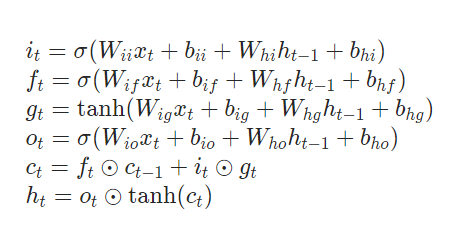




In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import pandas as pd
from collections import Counter
import numpy as np

class Model(nn.Module):
    def __init__(self, dataset):
        super(Model, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_words)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = nn.Linear(self.lstm_size, n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits, state

    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size))

# Dealing with data

---



1.   Break into words
2.   Make a vocabulary and one hot encode
3.   Predict the next word



In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, seq_len):
        self.sequence_length = seq_len
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()
        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}
        self.words_indexes = [self.word_to_index[w] for w in self.words]

    def load_words(self):
        train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/reddit-cleanjokes.csv')
        text = train_df['Joke'].str.cat(sep=' ')
        return text.split(' ')

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.words_indexes) - self.sequence_length

    def __getitem__(self, index):
        return (torch.tensor(self.words_indexes[index:index+self.sequence_length]),
                torch.tensor(self.words_indexes[index+1:index+self.sequence_length+1]),)
    def get_instance(self, index):
        inp = ' '.join([self.index_to_word[i] for i in self.words_indexes[index:index+self.sequence_length]])
        outp = ' '.join([self.index_to_word[i] for i in self.words_indexes[index+1:index+self.sequence_length+1]])
        return f'X: {inp} \nY: {outp}'

# Train 

---



In [ ]:
def train(dataset, model, sequence_length, batch_size, max_epochs):
    model.train()

    dataloader = DataLoader(dataset, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(max_epochs):
        state_h, state_c = model.init_state(sequence_length)

        for batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()

            y_pred, (state_h, state_c) = model(x, (state_h, state_c))
            loss = criterion(y_pred.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()

            loss.backward()
            optimizer.step()
            if batch%100 == 0:
              print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })

# Predict

---



In [ ]:
def predict(dataset, model, text, next_words=10):
    model.eval()

    words = text.split(' ')
    state_h, state_c = model.init_state(len(words))

    for i in range(0, next_words):
        x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]])
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))

        last_word_logits = y_pred[0][-1]
        probs = torch.nn.functional.softmax(last_word_logits, dim=0)
        #_, contenders = torch.topk(probs, 3)
        p = probs.detach().numpy()
       

        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(dataset.index_to_word[word_index])
        #print([dataset.index_to_word[i] for i in contenders.detach().tolist()])

    return words

In [66]:
max_epochs=10
batch_size=64
sequence_length=7

dataset = Dataset(sequence_length)
print(len(dataset))
print(dataset.get_instance(0))
model = Model(dataset)

23907
X: What did the bartender say to the 
Y: did the bartender say to the jumper


In [67]:
train(dataset, model, sequence_length, batch_size, max_epochs)

{'epoch': 0, 'batch': 0, 'loss': 8.851799964904785}
{'epoch': 0, 'batch': 100, 'loss': 7.205977439880371}
{'epoch': 0, 'batch': 200, 'loss': 7.60495662689209}
{'epoch': 0, 'batch': 300, 'loss': 7.38291597366333}
{'epoch': 1, 'batch': 0, 'loss': 6.580226421356201}
{'epoch': 1, 'batch': 100, 'loss': 6.6428985595703125}
{'epoch': 1, 'batch': 200, 'loss': 7.041805744171143}
{'epoch': 1, 'batch': 300, 'loss': 6.6426239013671875}
{'epoch': 2, 'batch': 0, 'loss': 6.230533599853516}
{'epoch': 2, 'batch': 100, 'loss': 6.341907501220703}
{'epoch': 2, 'batch': 200, 'loss': 6.736905097961426}
{'epoch': 2, 'batch': 300, 'loss': 6.390449047088623}
{'epoch': 3, 'batch': 0, 'loss': 6.030958652496338}
{'epoch': 3, 'batch': 100, 'loss': 6.126128196716309}
{'epoch': 3, 'batch': 200, 'loss': 6.374168395996094}
{'epoch': 3, 'batch': 300, 'loss': 6.057765007019043}
{'epoch': 4, 'batch': 0, 'loss': 5.791664123535156}
{'epoch': 4, 'batch': 100, 'loss': 5.998005390167236}
{'epoch': 4, 'batch': 200, 'loss': 5.9

In [68]:
output = predict(dataset, model, text='Knock knock Whos there?')
print(" ".join(output))

Knock knock Whos there? c/o artificial bike constipated, in the Olympic Someone until he
